# Visualize RNA-seq, ATAC-seq, and bimodal input

In [1]:
# import needed modules:

# general python utilities
import os
import platform
import random
import shutil
import sys
import time
import datetime
import functools
import itertools as it
import copy

# recommended Python3 version >= 3.5
print('Python version: {}'.format(platform.sys.version))

# data-science & processing tools
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import h5py
import scanpy as sc
import anndata as ann


# progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm_notebook as tqdm

# plotting utilities
import seaborn as sns
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
import tensorflow.keras as K

# required TensorFlow version >= 2.0.0
tf_version = tf.__version__
print('TensorFlow version: {}'.format(tf_version))
assert int(tf_version[0]) >= 2, "Tensorflow version must be >= 2.0"

# seed random numbers for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print('\nImports Complete.')

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) 
[Clang 9.0.1 ]
TensorFlow version: 2.1.0

Imports Complete.


## Load Data

In [17]:
''' Load in matrices generated after pre-processing steps '''
PATH = os.getcwd() # make sure cwd is 6_874-Multimodal-DL
OUTPUTS = os.path.join(PATH, 'Outputs')
atac_data_path = os.path.join(OUTPUTS, 'atacMatrix1_clean1')
rna_data_path = os.path.join(OUTPUTS, 'rnaMatrix_clean1')
bimodal_data_path = os.path.join(OUTPUTS, 'bimodalEarlyFusionMatrix_clean1')

# save as pandas dataframes
atac_df = pd.read_hdf(atac_data_path)
rna_df = pd.read_hdf(rna_data_path)
bimodal_df = pd.read_hdf(bimodal_data_path)

In [18]:
atac_df.head()

,sample,matrix,treatment_time,atac_1,atac_2,atac_4,atac_10,atac_17,atac_22,atac_24,...,atac_189594,atac_189595,atac_189596,atac_189597,atac_189598,atac_189599,atac_189600,atac_189601,atac_189602,atac_189603
0,sci-RNA-A-001.AAGTACGTTA,829,3h,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sci-RNA-A-001.CGTATTGAGA,830,3h,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sci-RNA-A-001.GACCAATGCG,828,0h,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sci-RNA-A-001.TCTCTCATCC,832,0h,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sci-RNA-A-002.AAGTACGTTA,89,3h,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Observations**: 
- There are over 20,000 features, but only 3260 samples. Consider using PCA or another dimensionality reduction method before inputing into network
- This matrix is super sparse. Think about how to account for that (maybe in feature selection)
- TODO - feature selection

In [19]:
''' Get feature labels '''
# get features
atac_features = atac_df.loc[:, 'atac_1':].columns
rna_features = rna_df.loc[:, 'rna_2':].columns
bimodal_features = bimodal_df.loc[:, 'rna_2':].columns

# get number of features
n_atac_features = len(atac_features)
n_rna_features = len(rna_features)
n_bi_features = len(bimodal_features)

In [20]:
bimodal_df.head()

,sample,matrix_x,treatment_time_x,rna_2,rna_8,rna_11,rna_12,rna_15,rna_18,rna_20,...,atac_189594,atac_189595,atac_189596,atac_189597,atac_189598,atac_189599,atac_189600,atac_189601,atac_189602,atac_189603
0,sci-RNA-A-001.AAGTACGTTA,2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sci-RNA-A-001.CGTATTGAGA,16,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sci-RNA-A-001.GACCAATGCG,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sci-RNA-A-001.TCTCTCATCC,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sci-RNA-A-002.AAGTACGTTA,18,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## UMAP plots

In [21]:
''' Try plotting with UMAP (later)'''
''' Create AnnData object'''
def create_AnnData_from_df(df, obs='treatment_time', label_cutoff_ix=5):
    '''
        @params:
        Given spectra df, creates AnnData matrix
        label_cutoff_ix: columns index where spectral data begins
        
        @returns: annData object
    '''
    obs_nonspatial = pd.DataFrame(df[obs])
    var_nonspatial = pd.DataFrame(df.iloc[:,label_cutoff_ix:].columns)
    signal = df.iloc[:,label_cutoff_ix:].to_numpy()
    ann_df = ann.AnnData(X=signal)
    
    # change variable and observation names
    ann_df.obs = obs_nonspatial
    ann_df.var = var_nonspatial
    
    return ann_df

In [22]:
atac_df['treatment_time'] = list(map(str, atac_df['treatment_time']))

In [23]:
rna_df['treatment_time'] = list(map(str, rna_df['treatment_time']))

In [24]:
bimodal_df['treatment_time_x'] = list(map(str, bimodal_df['treatment_time_x']))

In [25]:
''' Create AnnData objects'''
ann_atac = create_AnnData_from_df(atac_df, obs='treatment_time', label_cutoff_ix=3)
ann_rna = create_AnnData_from_df(rna_df, obs='treatment_time', label_cutoff_ix=3)
ann_bimodal = create_AnnData_from_df(bimodal_df, obs='treatment_time_x', label_cutoff_ix=3)

AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 


In [26]:
def UMAP(df):
    sc.tl.pca(df)
    # sc.pl.pca(df, color='day')
    # sc.pl.pca_variance_ratio(df, log=True)
    sc.pp.neighbors(df)
    sc.tl.umap(df)

In [27]:
UMAP(ann_atac)

In [28]:
UMAP(ann_rna)

In [29]:
UMAP(ann_bimodal)

... storing 'treatment_time' as categorical


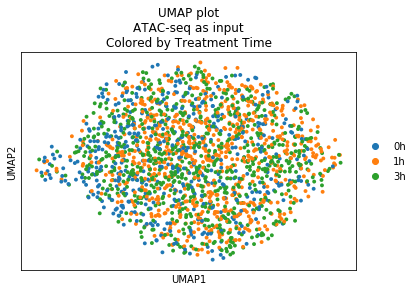

... storing 'treatment_time' as categorical


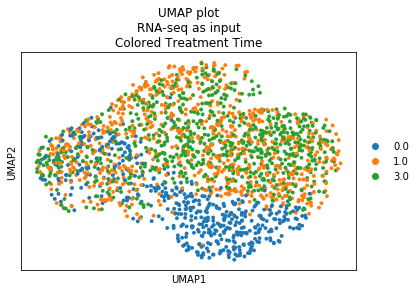

... storing 'treatment_time_x' as categorical


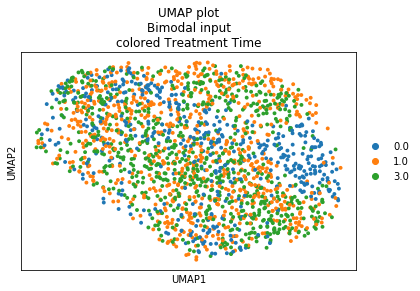

In [30]:
''' Plot UMAPs'''
sc.pl.umap(ann_atac, color=['treatment_time'], 
              title=['UMAP plot\nATAC-seq as input\nColored by Treatment Time'],)
              # palette='Purples')

sc.pl.umap(ann_rna, color=['treatment_time'], 
              title=['UMAP plot\nRNA-seq as input\nColored Treatment Time'])
              #palette='Purples')
    
sc.pl.umap(ann_bimodal, color=['treatment_time_x'], 
            title=['UMAP plot\nBimodal input\ncolored Treatment Time'])
              #palette='Purples')

In [31]:
atac_df['treatment_time'].value_counts()

3h    756
1h    751
0h    485
Name: treatment_time, dtype: int64

In [32]:
rna_df['treatment_time'].value_counts()

3.0    756
1.0    751
0.0    485
Name: treatment_time, dtype: int64

In [33]:
bimodal_df['treatment_time_x'].value_counts()

3.0    756
1.0    751
0.0    485
Name: treatment_time_x, dtype: int64

##### **Observation**: These datasets are not balanced. The bimodal df has far more cells treated for 3 hours than for 0 hours

## t-SNE Plots

In [34]:
''' Get X coordinates'''
atac_np = atac_df.iloc[:,3:].to_numpy()
rna_np = rna_df.iloc[:,3:].to_numpy()
bimodal_np = bimodal_df.iloc[:,3:].to_numpy()

In [35]:
''' Get y coordinates'''
atac_labels = atac_df['treatment_time']
rna_labels =  rna_df['treatment_time']
bimodal_labels = bimodal_df['treatment_time_x']

In [36]:
''' Reduce dimensionality using PCA '''
a_pca = PCA(n_components=50)
atac_pca = a_pca.fit_transform(atac_np)

r_pca = PCA(n_components=50)
rna_pca = r_pca.fit_transform(rna_np)

b_pca = PCA(n_components=50)
bimodal_pca = a_pca.fit_transform(bimodal_np)

In [37]:
atac_embedded = TSNE(n_components=2).fit_transform(atac_pca)

In [38]:
rna_embedded = TSNE(n_components=2).fit_transform(rna_pca)

In [39]:
bimodal_embedded = TSNE(n_components=2).fit_transform(bimodal_pca)

In [56]:
''' Plot t-SNE plots '''
atac_0 = atac_labels == '0h'
atac_1 = atac_labels == '1h'
atac_3 = atac_labels == '3h'

In [57]:
atac_embedded[atac_0][:,0].shape, atac_embedded[atac_1][:,0].shape, atac_embedded[atac_3][:,0].shape

((485,), (751,), (756,))

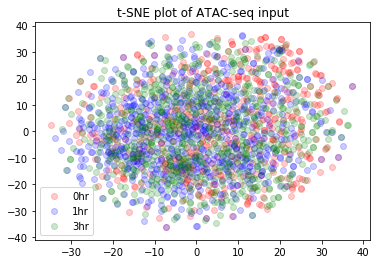

In [82]:
plt.scatter(atac_embedded[atac_0][:,0], atac_embedded[atac_0][:,1],color='red', alpha=0.2)
plt.scatter(atac_embedded[atac_1][:,0], atac_embedded[atac_1][:,1],color='blue', alpha=0.2)
plt.scatter(atac_embedded[atac_3][:,0], atac_embedded[atac_3][:,1],color='green', alpha=0.2)
plt.title('t-SNE plot of ATAC-seq input')
plt.legend(['0hr', '1hr', '3hr']);

In [73]:
''' Plot t-SNE plots '''
rna_0 = rna_labels == '0.0'
rna_1 = rna_labels == '1.0'
rna_3 = rna_labels == '3.0'

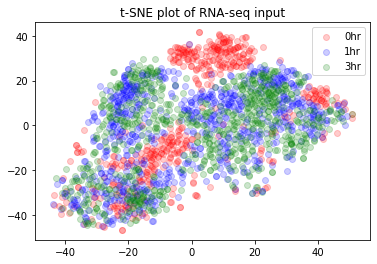

In [81]:
plt.scatter(rna_embedded[rna_0][:,0], rna_embedded[rna_0][:,1],color='red', alpha=0.2)
plt.scatter(rna_embedded[rna_1][:,0], rna_embedded[rna_1][:,1],color='blue', alpha=0.2)
plt.scatter(rna_embedded[rna_3][:,0], rna_embedded[rna_3][:,1],color='green', alpha=0.2)
plt.title('t-SNE plot of RNA-seq input');
plt.legend(['0hr', '1hr', '3hr']);

In [76]:
''' Plot t-SNE plots '''
bi_0 = bimodal_labels == '0.0'
bi_1 = bimodal_labels == '1.0'
bi_3 = bimodal_labels == '3.0'

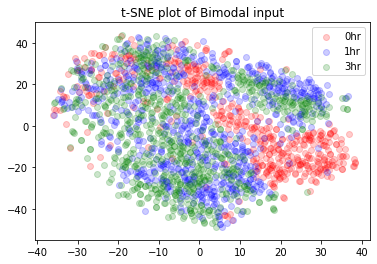

In [80]:
plt.scatter(bimodal_embedded[bi_0][:,0], bimodal_embedded[bi_0][:,1],color='red', alpha=0.2)
plt.scatter(bimodal_embedded[bi_1][:,0], bimodal_embedded[bi_1][:,1],color='blue', alpha=0.2)
plt.scatter(bimodal_embedded[bi_3][:,0], bimodal_embedded[bi_3][:,1],color='green', alpha=0.2)
plt.title('t-SNE plot of Bimodal input');
plt.legend(['0hr', '1hr', '3hr']);